# Semester 1 Project Submission

Please fill out:
* Student name: Cristian González Ramírez
* Instructor name: Nick McCarty & Julian Ward

# This notebook tries to answer to the following question:

*How are the production budgets for movies based on their genre in comparison to their income? Would it be profitable?*

For this question specifically, we are interested on knowing the Production Costs, the Total Gross (both domestic and foreign) and the Genres of each movie. This information can be easily foundin the following dataframes and tables:
* `movie_budgets`
* `SQL im.db"`

## Retreiving and cleaning data up

### Importing libraries
We will start by adding the basic libraries to our notebook, so it runs nice and smoothly.

In [1]:
# Import all libraries the project will requiere

#For retreiving data
import pandas as pd
import sqlite3
import zipfile

#For analyzing data
from scipy import stats
import numpy as np

#For plotting and visulaizations
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

### Retreiving general information
Then, we insert the data we will be working with.

In [2]:
#Retrieving data to work with
movie_budgets    = pd.read_csv("zippedData/tn.movie_budgets.csv.gz")

In [3]:
#Oppening SQLite3 zip
with zipfile.ZipFile("zippedData/im.db.zip", "r") as zObject:
        zObject.extractall()

conn = sqlite3.connect("im.db")

### Cleaning Movie Budgets data

Before starting any anylisis at all, we have to be sure that the data we are dealing with is ready to be manipulated. In order to accopmlish that, we must clean the data from all the tables using diffent data cleaning techniques.

First we will start with `movie_budget`.

In [4]:
movie_budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [5]:
movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


As we see all of the values are a `Not-Null`, so most of the job is done; even so that is not the end of it, there are still a few considerations that must be taken.

Here we check if there is any movie appearing more than once.

In [6]:
print(len(movie_budgets.movie.unique()), movie_budgets.shape[0])

5698 5782


Since these two numbers differ, we must take a look into it and remove any duplicates if any.

In [7]:
movie_budgets.movie.value_counts()

King Kong                                                     3
Home                                                          3
Halloween                                                     3
RoboCop                                                       2
Point Break                                                   2
                                                             ..
Nowhere Boy                                                   1
Eagle Eye                                                     1
The Assassination of Jesse James by the Coward Robert Ford    1
Beyond Borders                                                1
Diner                                                         1
Name: movie, Length: 5698, dtype: int64

In fact, we have a bunch of repeating movies. We have to deal with them, so they only appear once.

In [8]:
movie_budgets.drop_duplicates(subset=["movie"], inplace=True)

In [9]:
print(len(movie_budgets.movie.unique()), movie_budgets.shape[0])

5698 5698


Now both values are similiar, which let us know that we got rid of duplicates perfectly.

When we ran the `.info()` command above, we also have found that `production_budget`, `domestic_gross` and `worldwide_gross` are object types, when we need them to be a numeric value, to perform further comparisons. So we have to take care of that issue too.

In [10]:
#Getting rid off commas so it can be casted
movie_budgets.production_budget.replace(",","",regex=True, inplace=True)
movie_budgets.domestic_gross.replace(",","",regex=True, inplace=True)
movie_budgets.worldwide_gross.replace(",","",regex=True, inplace=True)

#Getting rid off $
movie_budgets["production_budget"] = movie_budgets.production_budget.str.strip("$")
movie_budgets["domestic_gross"] = movie_budgets.domestic_gross.str.strip("$")
movie_budgets["worldwide_gross"] = movie_budgets.worldwide_gross.str.strip("$")

In [11]:
#Casting grosses as a floats
movie_budgets["production_budget"] = movie_budgets.production_budget.astype(float)
movie_budgets["domestic_gross"] = movie_budgets.domestic_gross.astype(float)
movie_budgets["worldwide_gross"] = movie_budgets.worldwide_gross.astype(float)

In [12]:
movie_budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,425000000.0,760507625.0,2.776345e+09
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09
2,3,"Jun 7, 2019",Dark Phoenix,350000000.0,42762350.0,1.497624e+08
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09


It could be useful to have a `profit_or_loss` column for easier analysis later.

In [13]:
movie_budgets["profit_or_loss"] = movie_budgets.worldwide_gross - movie_budgets.production_budget

A `relation_pro_los` column to visualize easily in percentage how does income related to budget could also be benefitial later on.

In [14]:
movie_budgets["relation_pro_los"] = movie_budgets.worldwide_gross/movie_budgets.production_budget

In [15]:
movie_budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,profit_or_loss,relation_pro_los
0,1,"Dec 18, 2009",Avatar,425000000.0,760507625.0,2.776345e+09,2.351345e+09,6.532577
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,6.350639e+08,2.546673
2,3,"Jun 7, 2019",Dark Phoenix,350000000.0,42762350.0,1.497624e+08,-2.002376e+08,0.427892
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,1.072414e+09,4.243841
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09,9.997217e+08,4.153696


### Retreiving Movie Ratings data
Now we get the info from the relevant SQL table for the analysis.

In [16]:
#Obtain relevant information from SQL database
query = '''
    SELECT
        movie_id AS "ID",
        primary_title AS "Title",
        original_title AS "Original Title",
        genres AS "Genres"
    FROM movie_basics
'''

#Assign the query to a pandas dataframe
movie_by_genre = pd.read_sql(query,conn)

In [17]:
movie_by_genre.head()

,ID,Title,Original Title,Genres
0,tt0063540,Sunghursh,Sunghursh,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,"Comedy,Drama,Fantasy"


### Cleaning SQL data

In [18]:
movie_by_genre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   ID              146144 non-null  object
 1   Title           146144 non-null  object
 2   Original Title  146123 non-null  object
 3   Genres          140736 non-null  object
dtypes: object(4)
memory usage: 4.5+ MB


We see that most of the data we obtained is mostly complete, having a few null-values in the `Genres` column, since that is the primary variable we are focusing on, the better way to approach this issue would be to simply drop those rows, but we will do that at the very end of the clean up.

We start taking care of some small values that could mess up our analysis.

We check and drop duplicates (if any) as before.

In [19]:
print(len(movie_by_genre.Title.unique()), movie_by_genre.shape[0])

136071 146144


In [20]:
movie_by_genre.Title.value_counts()

Home                                         24
Broken                                       20
The Return                                   20
Alone                                        16
Homecoming                                   16
                                             ..
Ai Weiwei: Never Sorry                        1
When The Tables Turn                          1
Im Land Dazwischen                            1
Virsa                                         1
Gibsy - Rukeli Trollmanns Kampf ums Leben     1
Name: Title, Length: 136071, dtype: int64

In [21]:
movie_by_genre.drop_duplicates(subset=["Title"], inplace=True)

In [22]:
print(len(movie_by_genre.Title.unique()), movie_by_genre.shape[0])

136071 136071


In [23]:
print(len(movie_by_genre["Original Title"].unique()), movie_by_genre["Original Title"].shape[0])

135756 136071


In [24]:
movie_by_genre["Original Title"].value_counts()

Missed Connections                           3
Icarus                                       3
Stranded                                     3
Hatsukoi                                     3
Mind's Eye                                   2
                                            ..
Luciana                                      1
Cheveux rouges et café noir                  1
The Rise and Fall of the Brown Buffalo       1
Muitos Homens Num Só                         1
Gibsy - Rukeli Trollmanns Kampf ums Leben    1
Name: Original Title, Length: 135755, dtype: int64

In [25]:
movie_by_genre.drop_duplicates(subset=["Original Title"], inplace = True)

In [26]:
print(len(movie_by_genre["Original Title"].unique()), movie_by_genre["Original Title"].shape[0])

135756 135756


We also check that every ID is unique.

In [27]:
movie_by_genre.ID.value_counts().sort_values(ascending = True)

tt7258306     1
tt9329998     1
tt4334266     1
tt9230398     1
tt3265482     1
             ..
tt10364022    1
tt1883251     1
tt3963150     1
tt2106613     1
tt3634104     1
Name: ID, Length: 135756, dtype: int64

And they are! There is no problem in the ID column. 

Now, most of the cleaning of this Dataframe is done. The next step to do is to decide how to procede with the missing values we saw in the Genres column. There are around 800 missing values, and dropping those columns won't represent as much of a loss, so we will proceed with this approach, since we will still have a significant population for analysis.

In [28]:
movie_by_genre = movie_by_genre[movie_by_genre.Genres.str.contains("None") == False]

In [29]:
movie_by_genre.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 130920 entries, 0 to 146143
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   ID              130920 non-null  object
 1   Title           130920 non-null  object
 2   Original Title  130920 non-null  object
 3   Genres          130920 non-null  object
dtypes: object(4)
memory usage: 5.0+ MB


We can see we have a dataframe without any null value or duplicates. We can consider this dataframe to be clean!

In [30]:
movie_by_genre.head()

,ID,Title,Original Title,Genres
0,tt0063540,Sunghursh,Sunghursh,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,"Comedy,Drama,Fantasy"


### Merging tables
Now, we shall proceed with joining the `movie_rating` dataframe with the `movie_budgets` one to proceed with the analysis. In this approach, we are using the `.merge()` method instead of `.join()` because we actually want information from both of the dataframes

In [31]:
movie_budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,profit_or_loss,relation_pro_los
0,1,"Dec 18, 2009",Avatar,425000000.0,760507625.0,2.776345e+09,2.351345e+09,6.532577
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,6.350639e+08,2.546673
2,3,"Jun 7, 2019",Dark Phoenix,350000000.0,42762350.0,1.497624e+08,-2.002376e+08,0.427892
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,1.072414e+09,4.243841
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09,9.997217e+08,4.153696


In [32]:
#Create a new Dataframe to store the merge
gross_and_genre = pd.merge(movie_budgets, movie_by_genre, how="inner", left_on="movie", right_on="Title")

In [33]:
gross_and_genre.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,profit_or_loss,relation_pro_los,ID,Title,Original Title,Genres
0,1,"Dec 18, 2009",Avatar,425000000.0,760507625.0,2.776345e+09,2.351345e+09,6.532577,tt1775309,Avatar,Abatâ,Horror
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,6.350639e+08,2.546673,tt1298650,Pirates of the Caribbean: On Stranger Tides,Pirates of the Caribbean: On Stranger Tides,"Action,Adventure,Fantasy"
2,3,"Jun 7, 2019",Dark Phoenix,350000000.0,42762350.0,1.497624e+08,-2.002376e+08,0.427892,tt6565702,Dark Phoenix,Dark Phoenix,"Action,Adventure,Sci-Fi"
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,1.072414e+09,4.243841,tt2395427,Avengers: Age of Ultron,Avengers: Age of Ultron,"Action,Adventure,Sci-Fi"
4,7,"Apr 27, 2018",Avengers: Infinity War,300000000.0,678815482.0,2.048134e+09,1.748134e+09,6.827114,tt4154756,Avengers: Infinity War,Avengers: Infinity War,"Action,Adventure,Sci-Fi"


Now we just do some visual cleaning.

In [34]:
#Deleting duplicated columns
del gross_and_genre["Title"]
del gross_and_genre["Original Title"]
del gross_and_genre["id"]

#Deleting columns that are not relevant to the analysis
del gross_and_genre["release_date"]

In [35]:
#Rearenging columns for easier lecture
gross_and_genre = gross_and_genre[["ID", "movie", "Genres","production_budget", 
                                     "domestic_gross", "worldwide_gross",
                                     "profit_or_loss", "relation_pro_los"]]

In [36]:
gross_and_genre.columns

Index(['ID', 'movie', 'Genres', 'production_budget', 'domestic_gross',
       'worldwide_gross', 'profit_or_loss', 'relation_pro_los'],
      dtype='object')

One last check to see if everything is in order.

In [37]:
gross_and_genre.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2276 entries, 0 to 2275
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 2276 non-null   object 
 1   movie              2276 non-null   object 
 2   Genres             2276 non-null   object 
 3   production_budget  2276 non-null   float64
 4   domestic_gross     2276 non-null   float64
 5   worldwide_gross    2276 non-null   float64
 6   profit_or_loss     2276 non-null   float64
 7   relation_pro_los   2276 non-null   float64
dtypes: float64(5), object(3)
memory usage: 160.0+ KB


And it is indeed.

In [38]:
gross_and_genre.head()

,ID,movie,Genres,production_budget,domestic_gross,worldwide_gross,profit_or_loss,relation_pro_los
0,tt1775309,Avatar,Horror,425000000.0,760507625.0,2.776345e+09,2.351345e+09,6.532577
1,tt1298650,Pirates of the Caribbean: On Stranger Tides,"Action,Adventure,Fantasy",410600000.0,241063875.0,1.045664e+09,6.350639e+08,2.546673
2,tt6565702,Dark Phoenix,"Action,Adventure,Sci-Fi",350000000.0,42762350.0,1.497624e+08,-2.002376e+08,0.427892
3,tt2395427,Avengers: Age of Ultron,"Action,Adventure,Sci-Fi",330600000.0,459005868.0,1.403014e+09,1.072414e+09,4.243841
4,tt4154756,Avengers: Infinity War,"Action,Adventure,Sci-Fi",300000000.0,678815482.0,2.048134e+09,1.748134e+09,6.827114


Finally, after getting all of our interest values together, the next step would be to jump into analysis, in which we compare the income of a movie based on its genre with the production budget it had.

## Performing Visual Analysis

Let us recall the question we are trying to solve:

*"How are the production budgets for movies based on their genre in comparison to their income? Would it be profitable?"*

Therefore, we have to compare every income of every genre, but as we can see, there are many movies that share genres, which may represent a problem while comparing them. Getting appart every genre into an individual one is out of the scope of this project, so each group of genres will be considered as an individual one and proceed with the analysis as they are. There is no major problem in this, because, as we will see, there are times in which a specific group of genres is more profitable than other and even to its no-groupped counterpart.

We organize the information to be easier to analyze in graphs.

In [39]:
#Grouping movies by genre
genre_gross_grouped = gross_and_genre.groupby(by="Genres", as_index=False).sum()

In [40]:
genre_gross_grouped.head()

,Genres,production_budget,domestic_gross,worldwide_gross,profit_or_loss,relation_pro_los
0,Action,7.470500e+08,6.095549e+08,1.229791e+09,4.827409e+08,28.518874
1,"Action,Adventure",2.985000e+08,2.736832e+08,6.657748e+08,3.672748e+08,4.896307
2,"Action,Adventure,Animation",1.957500e+09,2.664329e+09,7.435879e+09,5.478379e+09,69.716680
3,"Action,Adventure,Biography",3.200000e+08,2.521409e+08,8.825137e+08,5.625137e+08,10.178447
4,"Action,Adventure,Comedy",2.551500e+09,3.451585e+09,9.478284e+09,6.926784e+09,106.126157


We have to take care of an important issue here. Due to we used the `.sum()` command, all columns were summed up into a single value, including the `relation_pro_los` columns. If we take for example the first row value, it should be `1.9796` and it is `19.938754`. Allthoguh somewhat similar, not the same. The other columns represent no problem, since they are just money amounts and can be summed up straightforward, but a relationship cannot be sum. Hence, we gotta redo the relation operation with the new values.

In [41]:
genre_gross_grouped["relation_pro_los"] = genre_gross_grouped.worldwide_gross/genre_gross_grouped.production_budget

In [42]:
genre_gross_grouped.head()

,Genres,production_budget,domestic_gross,worldwide_gross,profit_or_loss,relation_pro_los
0,Action,7.470500e+08,6.095549e+08,1.229791e+09,4.827409e+08,1.646196
1,"Action,Adventure",2.985000e+08,2.736832e+08,6.657748e+08,3.672748e+08,2.230401
2,"Action,Adventure,Animation",1.957500e+09,2.664329e+09,7.435879e+09,5.478379e+09,3.798661
3,"Action,Adventure,Biography",3.200000e+08,2.521409e+08,8.825137e+08,5.625137e+08,2.757855
4,"Action,Adventure,Comedy",2.551500e+09,3.451585e+09,9.478284e+09,6.926784e+09,3.714789


And we take a sample of the population. In this case, we are going with 20 samples for clearer visualization.

In [43]:
#Getting data from most profitable to less profitable
genre_gross_top = genre_gross_grouped.sort_values(by="profit_or_loss", ascending=False).iloc[:20]
genre_gross_bottom = genre_gross_grouped.sort_values(by="profit_or_loss").iloc[:20]

In [44]:
genre_gross_top.head()

,Genres,production_budget,domestic_gross,worldwide_gross,profit_or_loss,relation_pro_los
12,"Action,Adventure,Sci-Fi",9.070400e+09,1.258900e+10,3.429490e+10,2.522450e+10,3.780969
71,"Adventure,Animation,Comedy",6.496500e+09,8.572619e+09,2.413066e+10,1.763416e+10,3.714409
8,"Action,Adventure,Fantasy",4.955600e+09,4.219500e+09,1.319146e+10,8.235863e+09,2.661930
4,"Action,Adventure,Comedy",2.551500e+09,3.451585e+09,9.478284e+09,6.926784e+09,3.714789
2,"Action,Adventure,Animation",1.957500e+09,2.664329e+09,7.435879e+09,5.478379e+09,3.798661


In [45]:
genre_gross_bottom.head()

,Genres,production_budget,domestic_gross,worldwide_gross,profit_or_loss,relation_pro_los
32,"Action,Crime,Fantasy",90000000.0,0.0,0.0,-90000000.0,0.000000
123,"Biography,Crime,Documentary",99000000.0,18985994.0,20813998.0,-78186002.0,0.210242
51,"Action,Family,Fantasy",90000000.0,195459.0,20466016.0,-69533984.0,0.227400
196,"Crime,Drama,History",92000000.0,12958326.0,27829311.0,-64170689.0,0.302493
189,"Comedy,Western",66000000.0,5909483.0,8446952.0,-57553048.0,0.127984


We can see, even after cleaning up, that we have ended up with a not very significant result, where when having a big budget, the total gross income is zero, and the genre had no revenue either domesticly or internationally. This surely cannot be a real case, and must have happened something when merging. So we will delete this row and add a new one so we still have the same amount of data.

In [46]:
genre_gross_bottom = genre_gross_grouped.sort_values(by="profit_or_loss").iloc[:(20+1)]
genre_gross_bottom.drop(index=32, inplace=True)
genre_gross_bottom.head()

,Genres,production_budget,domestic_gross,worldwide_gross,profit_or_loss,relation_pro_los
123,"Biography,Crime,Documentary",99000000.0,18985994.0,20813998.0,-78186002.0,0.210242
51,"Action,Family,Fantasy",90000000.0,195459.0,20466016.0,-69533984.0,0.227400
196,"Crime,Drama,History",92000000.0,12958326.0,27829311.0,-64170689.0,0.302493
189,"Comedy,Western",66000000.0,5909483.0,8446952.0,-57553048.0,0.127984
283,Romance,84425000.0,23589834.0,30825744.0,-53599256.0,0.365126


We can start plotting. First we are gonna plot the `Genres` with their `profit_or_loss` in order to see which are the ones with the highest and lowest incomes.

In [47]:
#This values represent different style values for the graphs
f1 = 15  #Figzise 1
f2 = 15  #Figsize 2
hs = 1.25   #Whitespace between graphs
fx = 16  #Fontsize x ticks
fy = 16  #Fontsize y ticks
ft = 20  #Fontsize title & labels

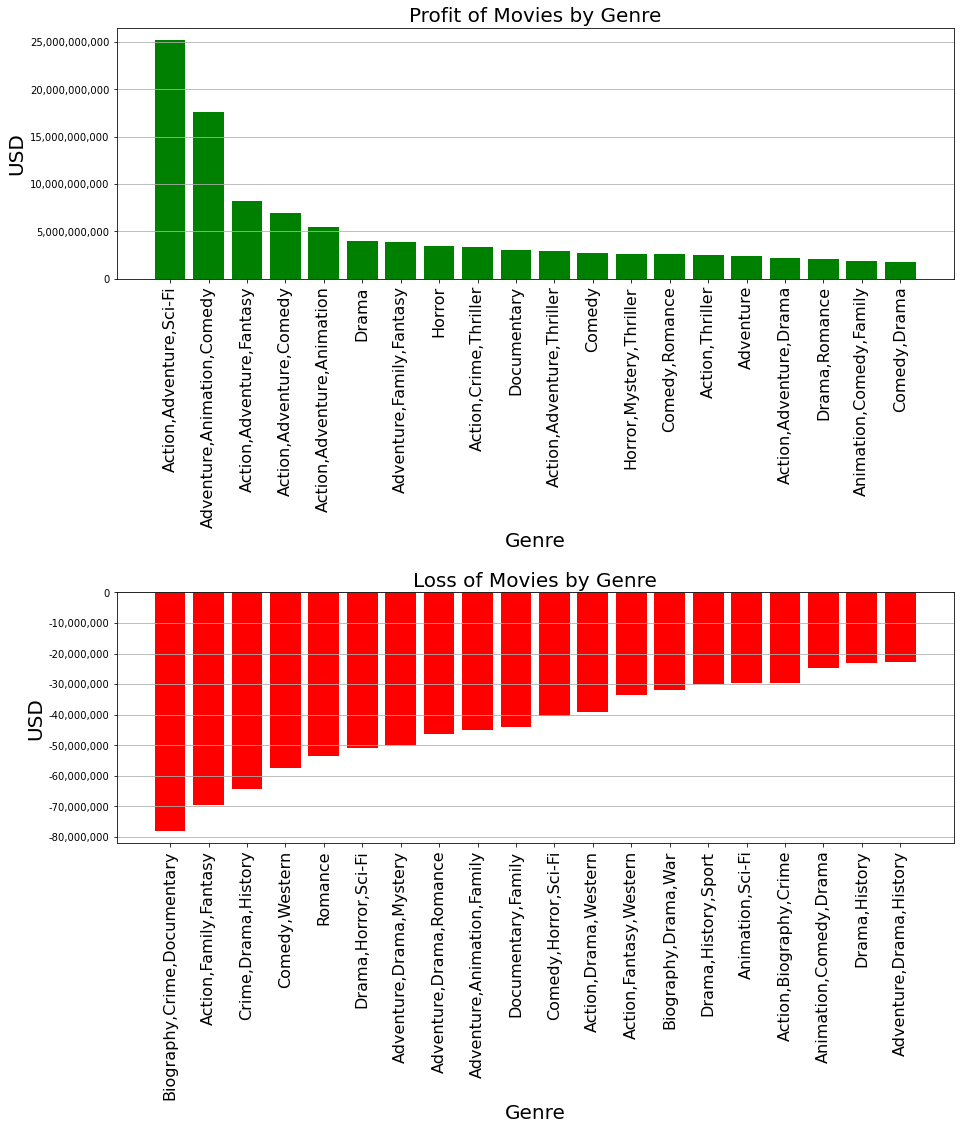

In [48]:
fig, (ax1, ax2) = plt.subplots(figsize=(f1,f2), nrows=2, ncols=1)

ax1.bar(genre_gross_top.Genres, genre_gross_top.profit_or_loss, color="g")

ax1.set_title("Profit of Movies by Genre", fontdict={"fontsize":ft})

plt.draw()
ax1.set_xticks(ax1.get_xticks())
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, fontdict={"fontsize":fx})

ax1.ticklabel_format(style="plain", axis="y")
ax1.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax1.set_xlabel("Genre", fontdict={"fontsize":ft})
ax1.set_ylabel("USD", fontdict={"fontsize":ft})
ax1.grid(axis="y")

#######

ax2.bar(genre_gross_bottom.Genres, genre_gross_bottom.profit_or_loss, color="r")
ax2.set_title("Loss of Movies by Genre", fontdict={"fontsize":ft})

plt.draw()
ax2.set_xticks(ax2.get_xticks())
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90, fontdict={"fontsize":fx})
ax2.ticklabel_format(style="plain", axis="y")
ax2.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax2.set_xlabel("Genre", fontdict={"fontsize":ft})
ax2.set_ylabel("USD", fontdict={"fontsize":ft})
ax2.grid(axis="y")

#######

plt.subplots_adjust(hspace=hs)
plt.show()

We can also have a visual comparison of the earnings with the budget.

In [49]:
wwg_top = genre_gross_top.sort_values(by="worldwide_gross", ascending=False)
wwg_bottom = genre_gross_bottom.sort_values(by="worldwide_gross", ascending=False)

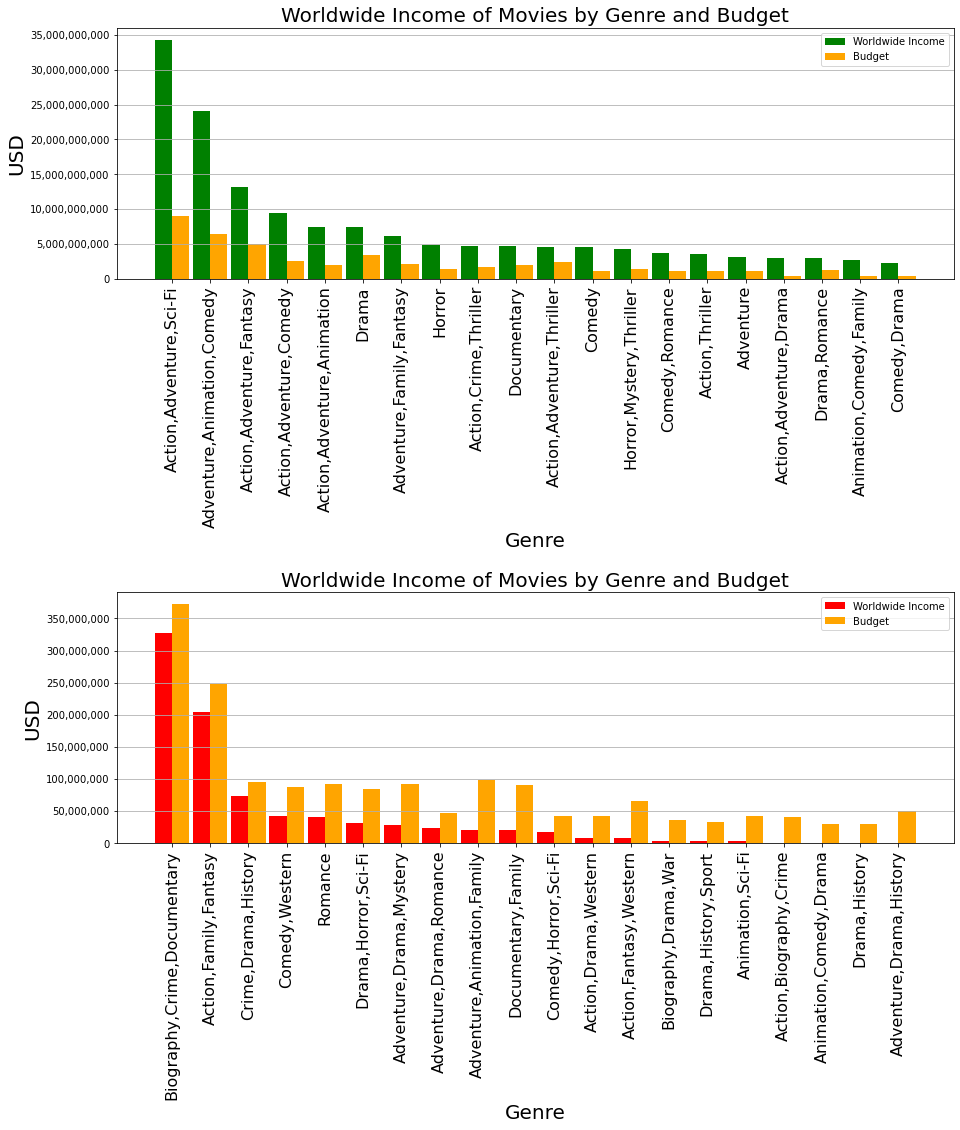

In [50]:
fig, (ax1, ax2) = plt.subplots(figsize=(f1,f2), nrows=2, ncols=1)

ax1.bar(genre_gross_top.Genres, wwg_top.worldwide_gross, width=-0.45, color="g", align="edge")
ax1.bar(genre_gross_top.Genres, wwg_top.production_budget, width=0.45, color="orange", align="edge")

ax1.set_title("Worldwide Income of Movies by Genre and Budget", fontdict={"fontsize":ft})


plt.draw()
ax1.set_xticks(ax1.get_xticks())
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, fontdict={"fontsize":fx})
ax1.ticklabel_format(style="plain", axis="y")
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))


ax1.set_xlabel("Genre", fontdict={"fontsize":ft})
ax1.set_ylabel("USD", fontdict={"fontsize":ft})
ax1.legend(labels=['Worldwide Income', 'Budget'])

ax1.grid(axis="y")

#######

ax2.bar(genre_gross_bottom.Genres, wwg_bottom.worldwide_gross, width=-0.45, color="r",align="edge")
ax2.bar(genre_gross_bottom.Genres, wwg_bottom.production_budget, width=0.45, color="orange", align="edge")

ax2.set_title("Worldwide Income of Movies by Genre and Budget", fontdict={"fontsize":ft})

plt.draw()
ax2.set_xticks(ax2.get_xticks())
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90, fontdict={"fontsize":fx})
ax2.ticklabel_format(style="plain", axis="y")
ax2.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax2.set_xlabel("Genre", fontdict={"fontsize":ft})
ax2.set_ylabel("USD", fontdict={"fontsize":ft})
ax2.legend(labels=['Worldwide Income', 'Budget'])

ax2.grid(axis="y")

#######
plt.subplots_adjust(hspace=hs)
plt.show()

It would be convenient to also do an analysis based on the relationship between the budget and the revenue; because, as we can see in the previous tables, some movies barely earn or loss the production budgets amount than others which may have even surpass it.

In [51]:
relation_top = genre_gross_top.sort_values(by="relation_pro_los", ascending=False)
relation_bottom = genre_gross_bottom.sort_values(by="relation_pro_los", ascending=False)

We plot again.

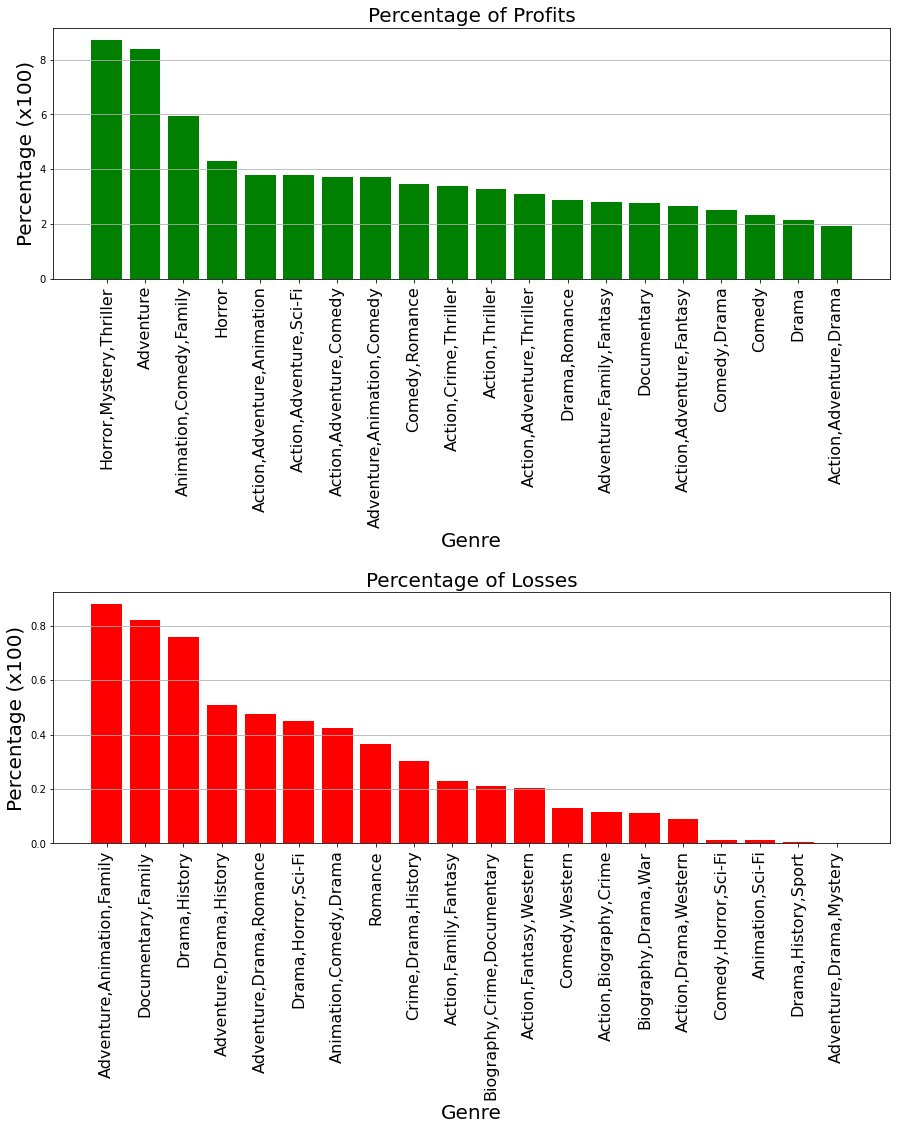

In [52]:
fig, (ax1, ax2) = plt.subplots(figsize=(f1,f2), nrows=2, ncols=1)

ax1.bar(relation_top.Genres, relation_top.relation_pro_los, color="g")

ax1.set_title("Percentage of Profits", fontdict={"fontsize":ft})

plt.draw()
ax1.set_xticks(ax1.get_xticks())
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, fontdict={"fontsize":fx})

ax1.set_xlabel("Genre", fontdict={"fontsize":ft})
ax1.set_ylabel("Percentage (x100)", fontdict={"fontsize":ft})
ax1.grid(axis="y")

#######

ax2.bar(relation_bottom.Genres, relation_bottom.relation_pro_los, color="r")
ax2.set_title("Percentage of Losses", fontdict={"fontsize":ft})

plt.draw()
ax2.set_xticks(ax2.get_xticks())
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90, fontdict={"fontsize":fx})

ax2.set_xlabel("Genre", fontdict={"fontsize":ft})
ax2.set_ylabel("Percentage (x100)", fontdict={"fontsize":ft})
ax2.grid(axis="y")

#######

plt.subplots_adjust(hspace=hs)
plt.show()

As we can see, even if the plots are somewhat similar, they have key differences that may be relevant for later analysis.

## Statistical Analysis

Now that we have got a bunch of information from visualization, it is time to be certain of what we are proposing, and for that matter we ougth to perform a statistical analysis which will let us know if our results are significant or not.

For that purpose we shall stablish what are we are trying to demonstrate: which genre is the most profitable in terms of budget and income? Before we saw visually that it could be the **Horror/Mystery/Thriller** group genre which had around $3 billion USD profit in relation to its budget. Now we will put statistics into it for more sifnificant results.

A good kind of hypotheses that would answer our question would be the following ones:

$H_0$: *Having a higher budget will not produce higher profit movies.*

$H_1$: *Having a higher budget will produce higher profit movies.*

Now we develop statistical analysis to find out which hypotheses would be correct. For that purpose we have to get some basic statistic values from our population to start working with, for example: mean, median, standard deviation and some more.

Our population is contained within the `genre_gross_grouped` dataframe.

In [53]:
genre_gross_mean = gross_and_genre.copy()

We get rid off of the columns we are not using.

In [54]:
del genre_gross_mean["movie"]
del genre_gross_mean["production_budget"]
del genre_gross_mean["domestic_gross"]
del genre_gross_mean["worldwide_gross"]
del genre_gross_mean["profit_or_loss"]
del genre_gross_mean["ID"]

And get our final population of genres.

In [55]:
genre_gross_mean = genre_gross_mean.groupby(by="Genres", as_index=False).mean()

In [56]:
genre_gross_mean.head()

,Genres,relation_pro_los
0,Action,1.500993
1,"Action,Adventure",1.224077
2,"Action,Adventure,Animation",4.100981
3,"Action,Adventure,Biography",2.544612
4,"Action,Adventure,Comedy",3.537539


We this data, we con now get the mean and standard deviation of the population.

In [57]:
pop_mean = genre_gross_mean.relation_pro_los.mean()
pop_std  = genre_gross_mean.relation_pro_los.std()

We also need to get our population sample, which we have decided that will be of 100 samples.

In [58]:
sample_genres = genre_gross_mean.sample(n=100)

We have to keep in mind that this sample will change everytime the code is run.

In [59]:
sample_genres

,Genres,relation_pro_los
271,"Horror,Music,Thriller",0.761501
181,"Comedy,Mystery,Thriller",0.133647
277,"Horror,Thriller",3.028382
76,"Adventure,Biography,Documentary",1.016262
229,"Drama,Fantasy,Music",7.123288
...,...,...
50,"Action,Drama,Western",0.075427
101,"Adventure,Drama,Western",7.207912
46,"Action,Drama,Sci-Fi",4.019286
59,"Action,Horror,Thriller",5.960215


We got the dispersion values for the samples.

In [60]:
sample_mean = sample_genres.relation_pro_los.mean()
sample_std  = sample_genres.relation_pro_los.std()
sample_size = sample_genres.shape[0]

#Define our significance level
alpha = 0.05

And we start performing the test, which in this case iz gona be a *z*-test since our sample size is bigger than 30.

We calculate the *z-score* value.

In [61]:
z = (sample_mean-pop_mean) / (pop_std/np.sqrt(sample_size))
z

0.43173036668967296

Depending on the value of the z-score we are using one of the following approaches:

In [62]:
if z<0:
    p = stats.norm.cdf(z)                 #For a lower-tailed test
elif (z>0) & (z<0.1):
    p = 2 * (1 - stats.norm.cdf(abs(z)))  #For a two-tailed test
else:
    p = 1 - stats.norm.cdf(z)             #For a upper-tailed test

p

0.33296869709190957

We plot a normal distribution of the data so we can visualize better how the data is allocated and be prepared on what to expect.

Mean:  3.7900864076591256 
STD:   7.698020775682141


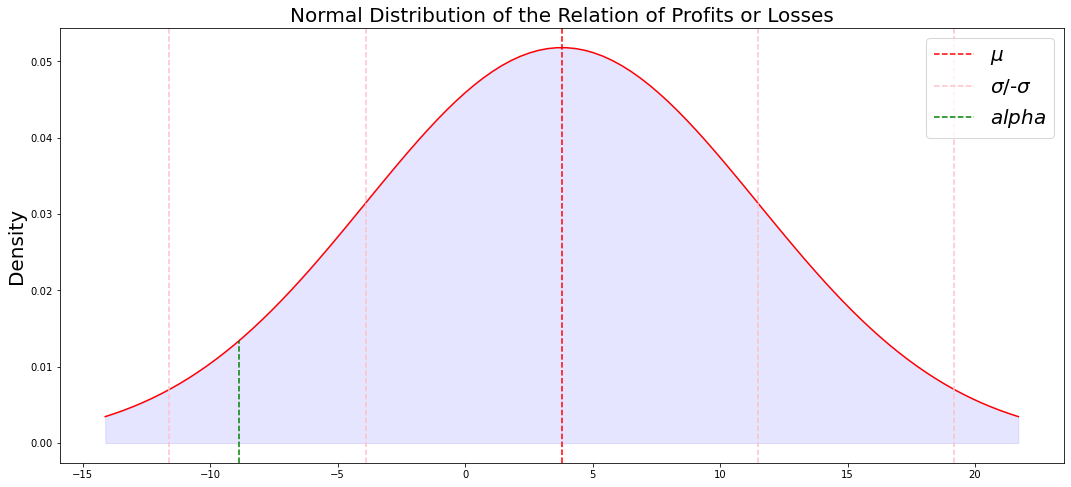

In [63]:
fig, ax = plt.subplots(figsize=(18,8))

x = np.linspace(
        stats.norm(sample_mean, sample_std).ppf(0.01), # Start plotting here
        stats.norm(sample_mean, sample_std).ppf(0.99), # End plotting here
        100                                            # Number of points
)

y = stats.norm(sample_mean,sample_std).pdf(x) #Generate normal function
alpha_interval = stats.norm(sample_mean, sample_std).ppf(0.05)

ax.plot(x, y,'r-')
ax.fill_between(x, y, 0, color='b', alpha=.1)

#Reference values
plt.axvline(x=sample_mean, color="r", label="$\mu$", linestyle="--")                               #Mean
plt.axvline(x=sample_std+sample_mean, color="pink", linestyle="--", label="$\sigma$/-$\sigma$")    #1 STD
plt.axvline(x=-sample_std+sample_mean, color="pink", linestyle="--")                               #-1 STD
plt.axvline(x=sample_std*2+sample_mean, color="pink", linestyle="--")                              #2 STD
plt.axvline(x=-sample_std*2+sample_mean, color="pink", linestyle="--")                             #-2 STD
plt.axvline(x=alpha_interval, ymax=0.28, color="g", label= "$alpha$", linestyle="--")               #alpha

#Graph label
plt.legend(prop={'size': 20})
ax.set_ylabel("Density", fontdict={"fontsize":ft})
ax.set_title("Normal Distribution of the Relation of Profits or Losses", fontdict={"fontsize": 20});

print("Mean: ", sample_mean, "\nSTD:  ", sample_std)

In [64]:
if p<alpha:
    print("We reject the Null-Hypothesis")
else:
    print("We fail to reject the Null-Hypothesis")

We fail to reject the Null-Hypothesis


Given that our *p-value* is bigger than the significance level we have established, we can conlcude that we fail to reject the Null-Hypothesis.

## Conclusion

Throughtout the visualizations of th graphs we saw many possible results. On one side, the "Worldwide Income of Movies by Genre and Budget" showed us that despite the budget assign to a movie porject, often the result tend to show huge incomes; but in the other, and with other data, the same graph showed that we can also deal with losses, although the revenue often stays nearby the initial budget.

Due to this uncertantity of knowing how much budget to assign to a project to see if it was profitable or not, we continued with a statistical analysis using the data that made up the "Percentage of Profit" and "Percentage of Losses"; where we find out that there is actually no relation between high budgets and low budgets and the income of a movie.

We could recommend though, to produce a movie among the top 10 most profitable genres and assign it a moderate budget, so in the case that it results that we could not retrieve the investment back, it would not be that much of a loss.